In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import requests
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import PIL
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction import text
from sklearn.metrics import confusion_matrix, r2_score
import xgboost as xgb

In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
def return_recipe(url, cuisine, i):
    try:
        recipe = requests.get(url).content
        soup = BeautifulSoup(recipe, 'lxml')
    except:
        return None
    try:
        title = soup.h1.text
    except:
        title = 'NA'
    if i % 10 == 0:
        print(i, title)
    try:
        calorie = soup.find('span', {'class':"calorie-count"})
        calorie = calorie.attrs['aria-label']
    except:
        calorie = 'NA'
    try:
        serve_size = soup.find('meta', {'itemprop':"recipeYield"})
        serve_size = serve_size.attrs['content']
    except:
        serve_size = 'NA'
    try:
        ready_time = soup.find('span', {'class':"ready-in-time"})
        ready_time = str(ready_time.text)
        #print(ready_time)
    except:
        ready_time = 'NA'
    try:
        rating = soup.find('div', {'class': 'rating-stars'})
        rating = rating.attrs['data-ratingstars']
    except:
        rating = 'NA'
    try:
        people_made_it = soup.find('span', {'class':'made-it-count'}).next.text
        people_made_it = people_made_it.split()[0]
    except:
        people_made_it = 'NA'
    try:
        review = soup.find('span', {'class':'review-count'})
        review = review.text
    except:
        review = 'NA'
    try:
        cook_times = soup.find_all('li', {'class':"prepTime__item"})
        cook_times = [i['aria-label'] for i in cook_times if len(i) > 1]
    except:
        cook_times = 'NA'
    try:
    #print(cook_times)
        ingredients_all = soup.find_all('label', {'ng-class':"{true: 'checkList__item'}[true]"})
        ingredients = [i['title'] for i in ingredients_all]
    except:
        ingredients = 'NA'
    
    #print(ingredients)
    return {'Cuisine': cuisine, 'title':title, 'Calorie':calorie, 'Serve_size': serve_size, 'Ready_time':ready_time,
           'Rating': rating, 'People_made_it': people_made_it, 'Review': review, 
            'Cook_time_all': cook_times, 'OriginalIngredients': ingredients}

In [4]:
def search_recipes(recipe_region, cuisine, no_page):
    urls = []
    for i in range(no_page):
        allrecipe_url = '{:s}/?page={:d}'.format(recipe_region, i)   
        allrecipe = requests.get(allrecipe_url).content
        soup = BeautifulSoup(allrecipe, 'lxml')
        tags = soup.find_all('a', {'class' : 'fixed-recipe-card__title-link', 'href': True})
        urls.extend([t['href'] for t in tags])
    recipes = []
    for i, url in enumerate(urls):
        recipes.append(return_recipe(url, cuisine, i))
    return pd.DataFrame(recipes)


In [5]:
cuisines = ['Italian', 'Chinese', 'Indian', 'Danish', 'Mexican', 'Southern', 'Japanese',
           'Middleeastern', 'Caribeean', 'Russian', 'French', 'Swedish', 'Ethiopia',
           'African', 'Peru', 'Brazil']
recipe_regions = ['https://www.allrecipes.com/recipes/723/world-cuisine/european/italian',
               'https://www.allrecipes.com/search/results/?wt=chinese',
               'https://www.allrecipes.com/recipes/233/world-cuisine/asian/indian',
              'https://www.allrecipes.com/search/results/?wt=scandinavian',
                 'https://www.allrecipes.com/recipes/728/world-cuisine/latin-american/mexican/',
                 'https://www.allrecipes.com/recipes/15876/us-recipes/southern/',
                'https://www.allrecipes.com/search/results/?wt=japanese',
                'https://www.allrecipes.com/search/results/?wt=middle%20eastern',
                 'https://www.allrecipes.com/search/results/?wt=caribbean',
                 'https://www.allrecipes.com/search/results/?wt=russia',
                 'https://www.allrecipes.com/search/results/?wt=french',
                 'https://www.allrecipes.com/search/results/?wt=swedish',
                 'https://www.allrecipes.com/search/results/?wt=ethiopia',
                 'https://www.allrecipes.com/search/results/?wt=african',
                 'https://www.allrecipes.com/search/results/?wt=peru',
                 'https://www.allrecipes.com/search/results/?wt=brazil']

In [ ]:
recipes_df = pd.DataFrame()
for c, r in zip(cuisines, recipe_regions):
    recipes_df = pd.concat([recipes_df, search_recipes(r, c, 15)])

In [7]:
recipes_df.shape

(4842, 17)

In [8]:
recipes_df.dtypes

Unnamed: 0             int64  
Calorie                float64
Cook_time_all          object 
Cuisine                object 
OriginalIngredients    object 
People_made_it         float64
Rating                 float64
Ready_time             object 
Review                 float64
Serve_size             float64
index                  float64
title                  object 
Preparation_time       float64
Cook_time              float64
Total_time             float64
Ingredients            object 
Merge_recipes          object 
dtype: object

In [ ]:
recipes_df.groupby(recipes_df.Cuisine)['title'].nunique()
recipes_df.Calorie = recipes_df.Calorie.str.split(expand=True)[0]
recipes_df['Preparation_time'] = recipes_df.Cook_time_all.str[0]
recipes_df.Preparation_time = recipes_df.Preparation_time.str.split(expand=True)[2]
recipes_df.Review = recipes_df.Review.str.split(expand=True)[0]

In [ ]:
recipes_df['Cook_time'] = recipes_df.Cook_time_all.str[1]
treci = recipes_df.Cook_time.str.split(expand=True)
treci[3] = treci[3].map({'Hours':60, 'Hour':60, 'Minute':1, 'Minutes':1,'Day':1440, 'Days':1440,})
treci[5] = treci[5].map({'Minutes':1})
recipes_df.Cook_time = (treci[2].apply(pd.to_numeric, errors='coerce') * treci[3]).fillna(0) + \
(treci[4].apply(pd.to_numeric, errors='coerce') * treci[5]).fillna(0)

In [43]:
def value_to_float(x):
    if 'k' in x:
        return float(x.replace('k', '')) * 1000
    elif 'NA' in x:
        return 0
    else:
        return float(x)

In [ ]:
recipes_df.People_made_it = recipes_df.People_made_it.astype(str).apply(value_to_float)
recipes_df.Preparation_time = recipes_df.Preparation_time.astype('float')
recipes_df.Calorie.fillna(0, inplace=True)
recipes_df.Calorie = recipes_df.Calorie.apply(pd.to_numeric, errors='coerce')
recipes_df.Rating = recipes_df.Rating.apply(pd.to_numeric, errors='coerce')
recipes_df['Total_time'] = recipes_df.Preparation_time + recipes_df.Cook_time

In [ ]:
s_without_removing_rows = []
for j in range(recipes_df.shape[0]):
    s = ''
    try:
        for i in range(25):
            try:
                s = s + ' ' + recipes_df.OriginalIngredients[j][i].split(' \'')[1]
            except:
                s = s + ' ' +  tingra[i].split(' \'')[0]
            else:
                pass
    except:
        pass
    try:
        s.replace('\[\'', '')
        s = s.replace(',', ' ')
        s = s.replace('\'', '')
        s = s[2:-2]
    except:
        s = 'NA'
    s_without_removing_rows.append(s)
recipes_df['Ingredients'] = s_without_removing_rows

In [ ]:
recipes_df.Ingredients = recipes_df.Ingredients.str.replace('\d+', '')
recipes_df.Ingredients = recipes_df.Ingredients.str.replace('/', '')
recipes_df.Ingredients = recipes_df.Ingredients.str.replace('.', '')
recipes_df.Ingredients = recipes_df.Ingredients.str.replace('(', '')
recipes_df.Ingredients = recipes_df.Ingredients.str.replace(')', '')
recipes_df.Ingredients = recipes_df.Ingredients.str.replace('-', ' ')

In [ ]:
lemmatizer = WordNetLemmatizer()
recipes_df.Ingredients = [lemmatizer.lemmatize(recipes_df.Ingredients[i]) 
          for i in range(recipes_df.Ingredients.shape[0])]
stopwords = set(STOPWORDS)
stopw = ['cup', 'tablespoon', 'tablespoons', 'pound', 'teaspoon', 'spoon', 'ounce', 'cups',
         'package', 'cut', 'inch', 'teaspoons', 'ounces', 'salt', 'water', 'chopped', 'pounds',
         'finely', 'taste', 'pinch', 'chopped', 'large', 'ground black', 'taste', 'thick', 
          'slices', 'slice', 'thinly', 'thin', 'minced', 'pieces', 'piece', 'needed', 'need', 
          'sliced']

In [ ]:
for s in nstopw:
    stopwords.add(s)

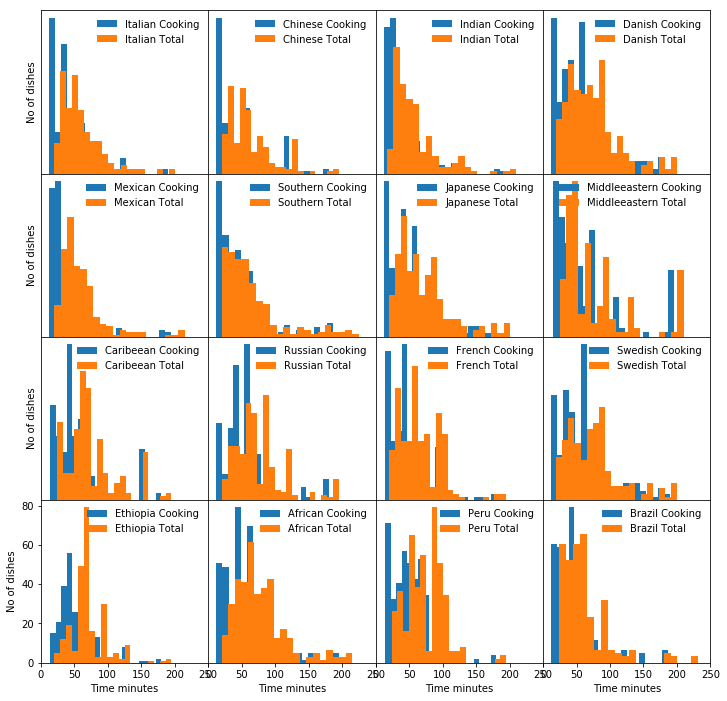

In [779]:
fig = plt.figure(figsize=(12, 12))
i = 1
for c in cuisines:
    ax = fig.add_subplot(4, 4, i)
    plt.hist(cuisine_cook.get_group(c)[(cuisine_cook.get_group(c) > 10)
                                       & (cuisine_cook.get_group(c) < 200)], 20,
            label=c + ' Cooking')
    plt.hist(cuisine_total.get_group(c)[(cuisine_cook.get_group(c) > 10)
                                       & (cuisine_cook.get_group(c) < 200)], 20,
            label=c + ' Total')
    
    plt.legend(loc=0, frameon=False)
    if i in [1, 5, 9, 13]:
        #pass #ax.set_yticks([])
        plt.ylabel('No of dishes')
    else:
        ax.set_yticks([])
    if i in [13, 14, 15, 16]:
        plt.xlabel('Time minutes')
        #pass
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.xlim(0, 250)
    i += 1
plt.subplots_adjust(hspace=0, wspace=0)


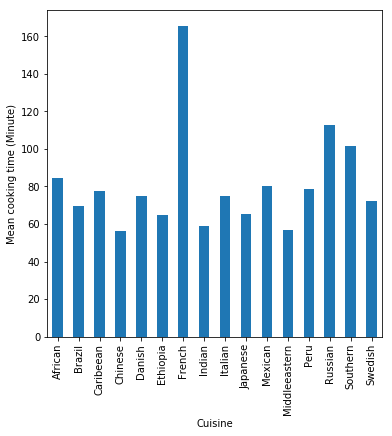

In [803]:
plt.figure(figsize=(6,6))
ax = recipes_df.groupby(recipes_df.Cuisine)['Total_time'].mean().plot(kind='bar')#, bins=30)
ax.set_ylabel('Mean cooking time (Minute)')
plt.savefig('cooking_bar.png')

(array([5., 5., 3., 0., 1., 1., 0., 0., 0., 1.]),
 array([ 56.20666667,  67.14466667,  78.08266667,  89.02066667,
         99.95866667, 110.89666667, 121.83466667, 132.77266667,
        143.71066667, 154.64866667, 165.58666667]),
 <a list of 10 Patch objects>)

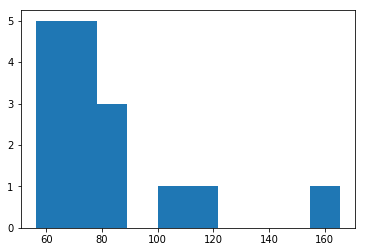

In [780]:
plt.hist(cuisine_total.mean())

In [181]:
cuisine_cal = recipes_df.groupby(recipes_df.Cuisine)['Calorie']

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


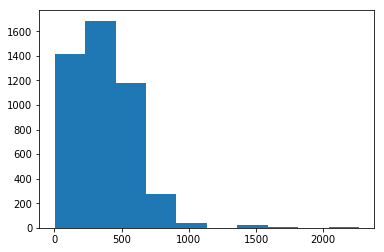

In [182]:
plt.hist(recipes_df.Calorie);

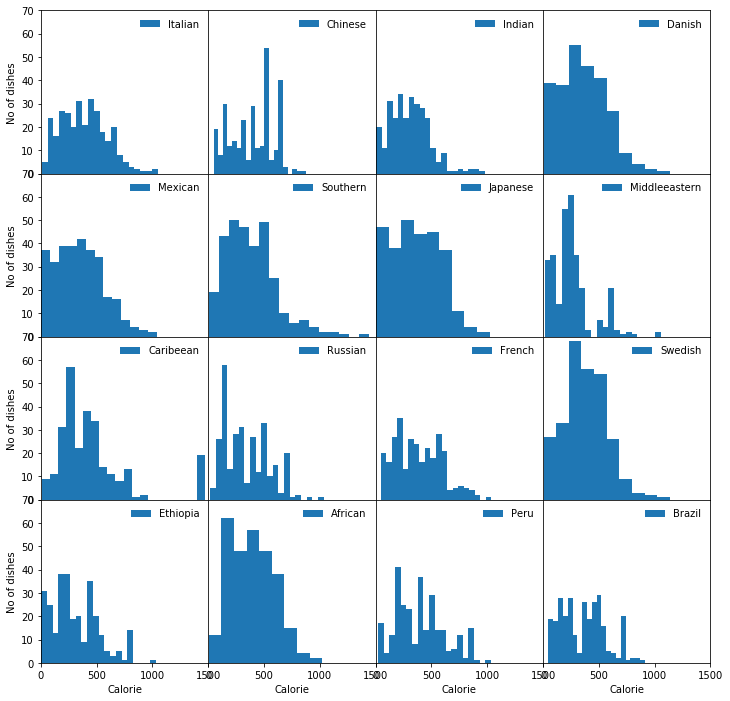

In [799]:
fig = plt.figure(figsize=(12, 12))
i = 1
for c in cuisines:
    ax = fig.add_subplot(4, 4, i)
    plt.hist(cuisine_cal.get_group(c), 20, label=c)
            
    plt.legend(loc=0, frameon=False)
    if i in [1, 5, 9, 13]:
        #pass 
        #ax.set_yticks([])
        plt.ylabel('No of dishes')
    else:
        ax.set_yticks([])
    if i in [13, 14, 15, 16]:
        plt.xlabel('Calorie')
        #pass
    else:
        ax.set_xticks([])
        #ax.set_yticks([])
    plt.xlim(0, 1500)
    plt.ylim(0, 70)
    i += 1
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('calorie_dist.png')

In [800]:
recipes_df.groupby(recipes_df.Cuisine)['Calorie'].mean()

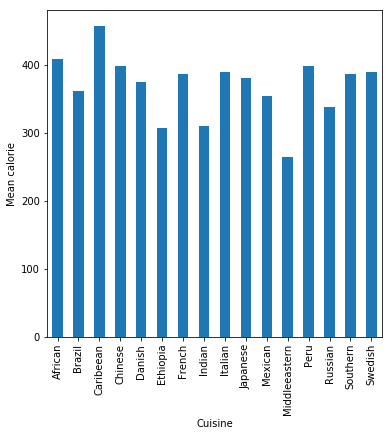

In [804]:
plt.figure(figsize=(6,6))
ax = recipes_df.groupby(recipes_df.Cuisine)['Calorie'].mean().plot(kind='bar')#, bins=30)
ax.set_ylabel('Mean calorie')
plt.savefig('calorie_bar.png')

In [812]:
recipe_title = recipes_df[recipes_df.Calorie > 800].groupby(recipes_df.Cuisine)['title']#.mean() #['title'].mean()

(0, 200)

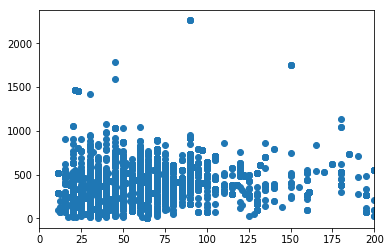

In [186]:
plt.scatter(recipes_df.Total_time[recipes_df.Total_time > 10], 
            recipes_df.Calorie[recipes_df.Total_time > 10])
plt.xlim(0, 200)

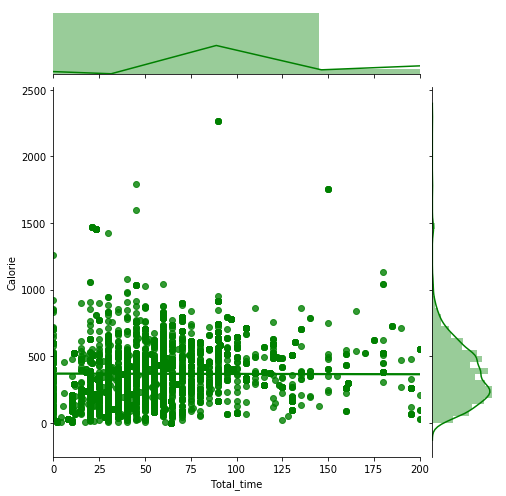

In [187]:
g = sns.jointplot('Total_time', 'Calorie', data=recipes_df, kind='reg',
                  xlim=(0, 200), color='g', height=7)

In [188]:
cuisine_review = recipes_df.groupby(recipes_df.Cuisine)['Review']

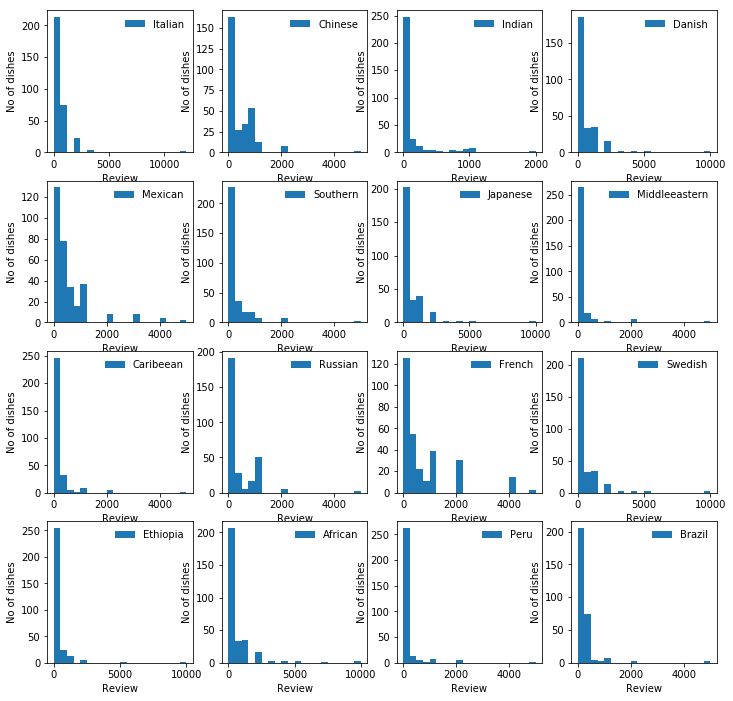

In [189]:
plt.figure(figsize=(12, 12))
i = 1
for c in cuisines:
    plt.subplot(4, 4, i)
    plt.hist(cuisine_review.get_group(c), 20, label=c)
    i += 1
    plt.legend(loc=0, frameon=False)
    plt.xlabel('Review')
    plt.ylabel('No of dishes');

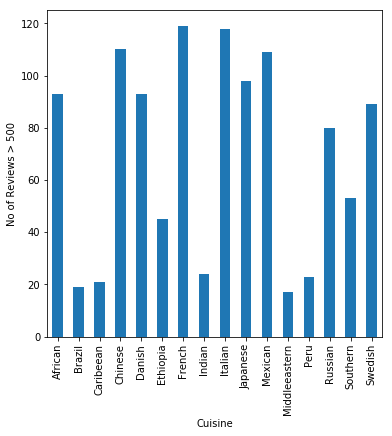

In [831]:
plt.figure(figsize=(6,6))
ax = recipes_df[recipes_df.Review > 500].groupby(recipes_df.Cuisine)['Cuisine'].size().plot(kind='bar')#, bins=30)
ax.set_ylabel('No of Reviews > 500')
plt.savefig('high_review_bar.png')



In [621]:
lemmatizer = WordNetLemmatizer()
tlemma = [lemmatizer.lemmatize(recipes_df.Ingredients[i]) 
          for i in range(recipes_df.Ingredients.shape[0])]

In [625]:
recipes_df.Ingredients = tlemma

In [1015]:
stopwords = set(STOPWORDS)
for s in stop_w:
    stopwords.add(s)

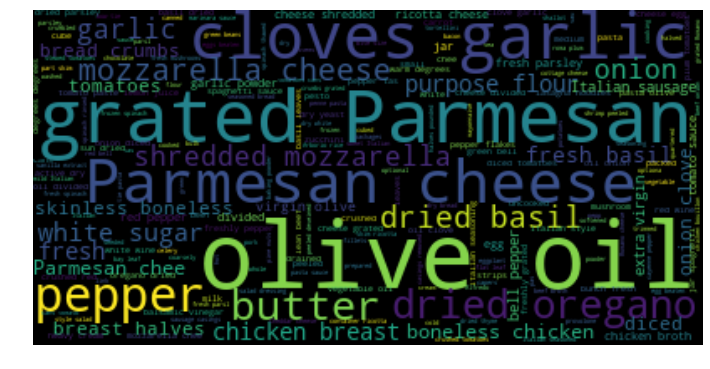

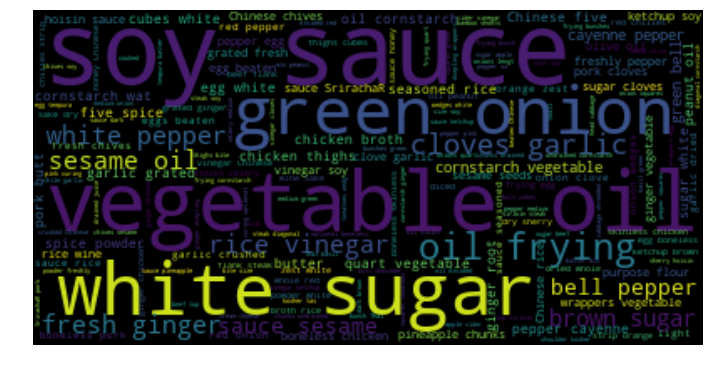

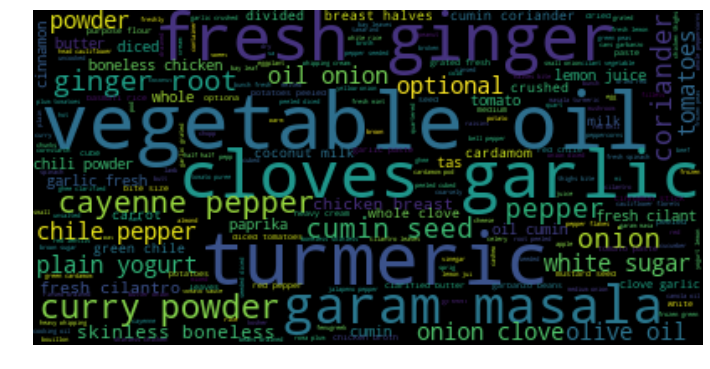

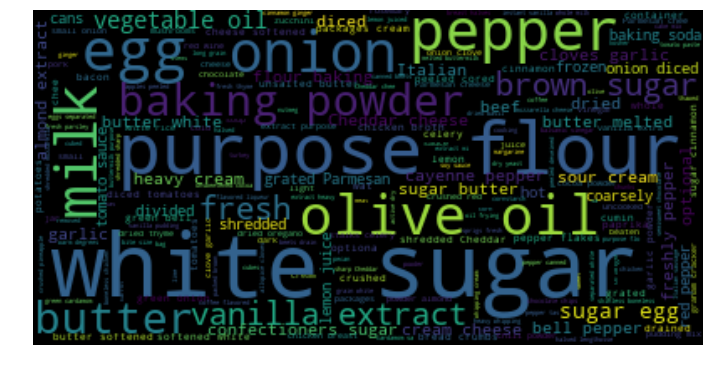

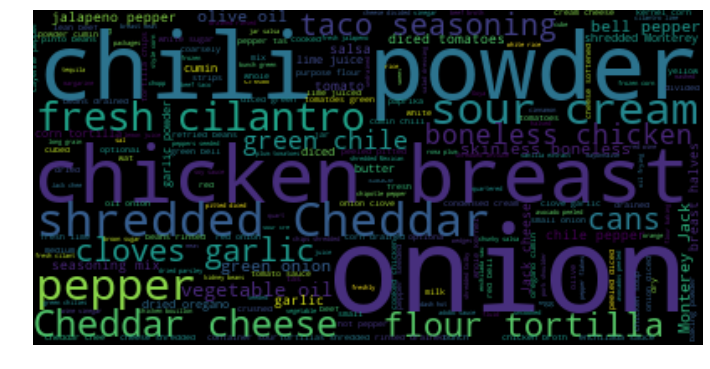

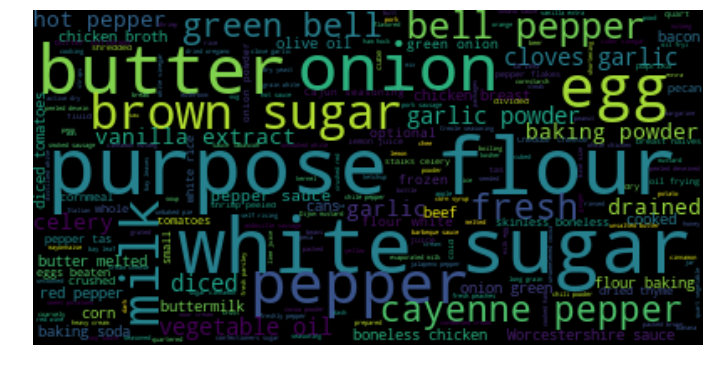

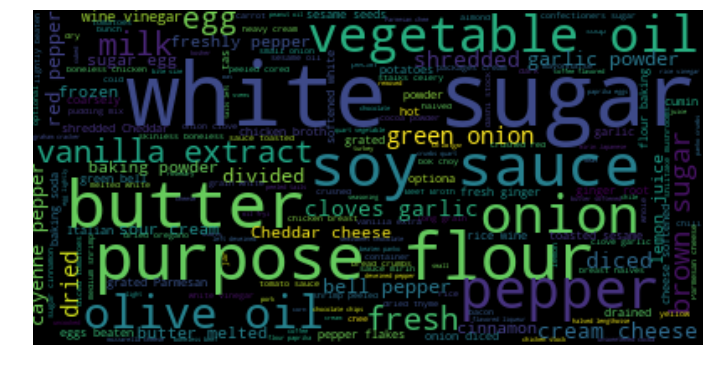

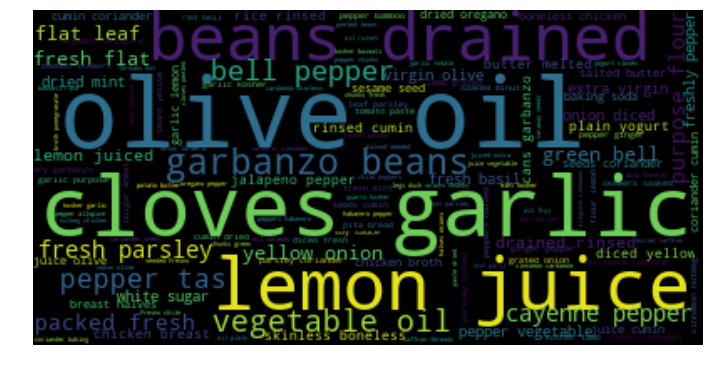

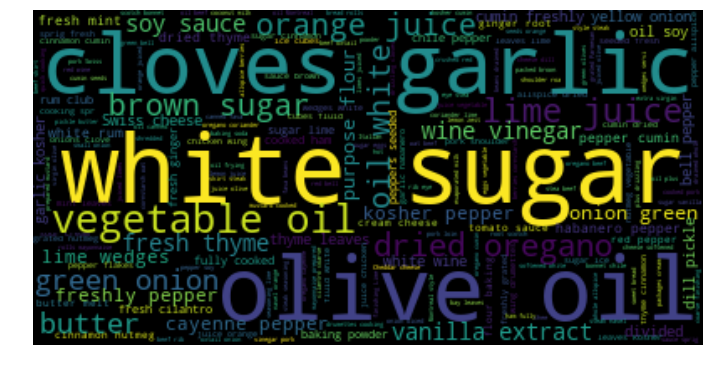

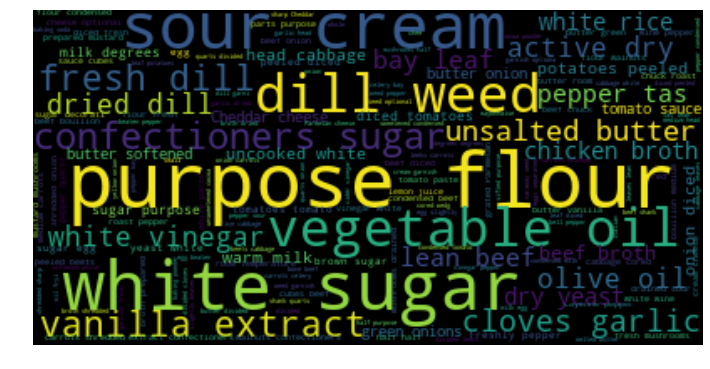

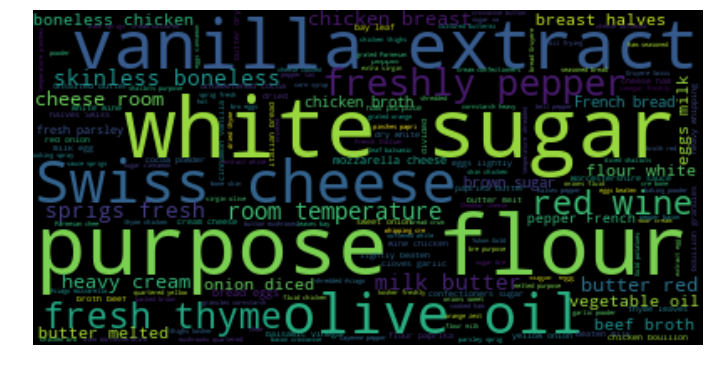

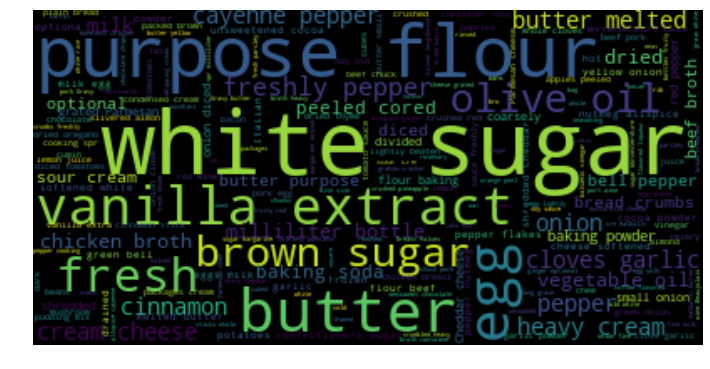

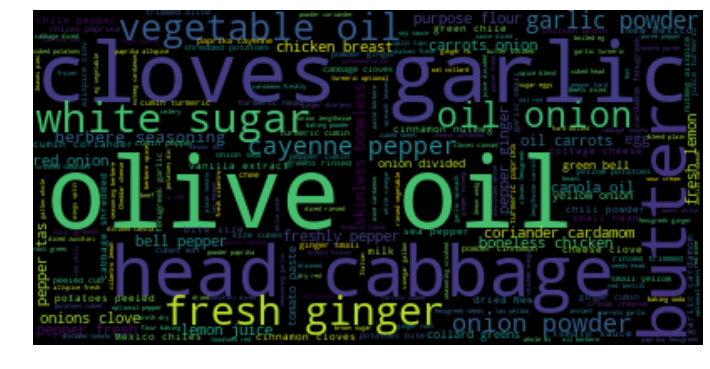

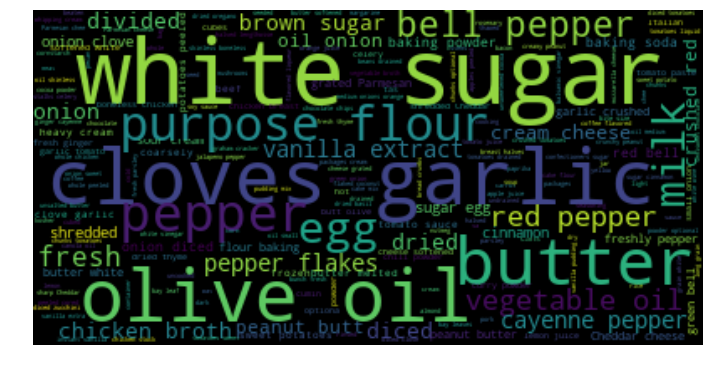

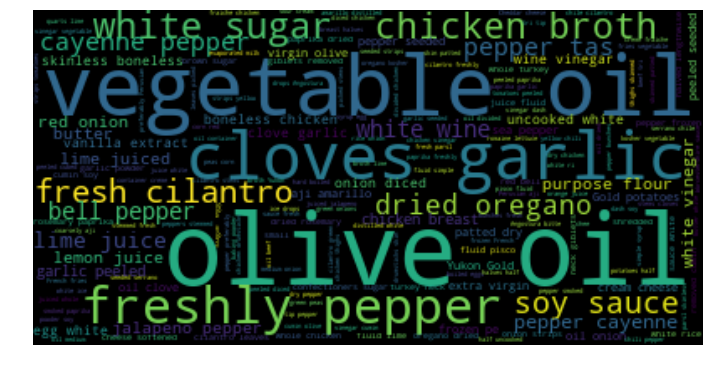

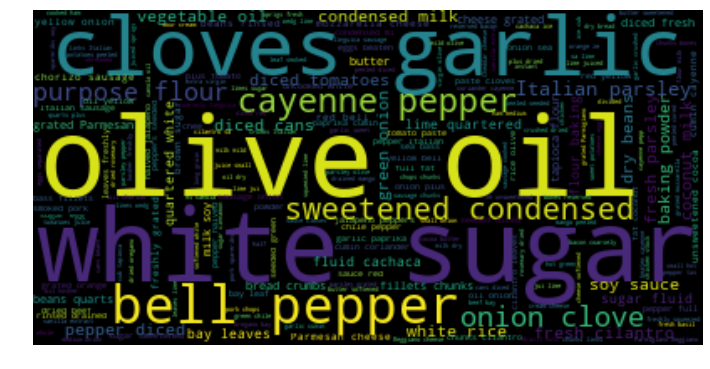

In [1016]:
for cuisine in cuisines:
    ingredients_str = recipes_df.Ingredients[recipes_df.Cuisine == cuisine].str.cat(sep=',')
    wordcloud = WordCloud(max_words=1000, margin=0, stopwords=stopwords).generate(ingredients_str)
    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('{:s}.png'.format(cuisine), bbox_inches='tight')
    plt.show()


In [315]:
recipes_df.Cuisine.unique()

array(['Italian', 'Indian', 'Mexican', 'Southern', 'Chinese', 'Danish',
       'Japanese', 'Middleeastern', 'Caribeean', 'Russian', 'French',
       'Swedish', 'Ethiopia', 'African', 'Peru', 'Brazil'], dtype=object)

In [864]:
merged_cuisines = ['Europian','African', 'Scandinavian', 'Southamerica', 'Asian', 'Indian', 
                   'Mexican', 'Southern', 'Middleeastern', 'Caribeean', 'Russian']

In [310]:
recipes_df['Merge_recipes'] = recipes_df.Cuisine.copy()

In [313]:
recipes_df.loc[recipes_df.Merge_recipes == 'Italian', 'Merge_recipes'] = 'Europian'

In [314]:
recipes_df.loc[recipes_df.Merge_recipes == 'French', 'Merge_recipes'] = 'Europian'

In [316]:
recipes_df.loc[recipes_df.Merge_recipes == 'Ethiopia', 'Merge_recipes'] = 'African'

In [317]:
recipes_df.loc[recipes_df.Merge_recipes == 'Danish', 'Merge_recipes'] = 'Scandinavian'
recipes_df.loc[recipes_df.Merge_recipes == 'Swedish', 'Merge_recipes'] = 'Scandinavian'

In [318]:
recipes_df.loc[recipes_df.Merge_recipes == 'Peru', 'Merge_recipes'] = 'Southamerica'
recipes_df.loc[recipes_df.Merge_recipes == 'Brazil', 'Merge_recipes'] = 'Southamerica'

In [319]:
recipes_df.loc[recipes_df.Merge_recipes == 'Chinese', 'Merge_recipes'] = 'Asian'
recipes_df.loc[recipes_df.Merge_recipes == 'Japanese', 'Merge_recipes'] = 'Asian'

In [320]:
recipes_df.Merge_recipes.unique()

array(['Europian', 'Indian', 'Mexican', 'Southern', 'Asian',
       'Scandinavian', 'Middleeastern', 'Caribeean', 'Russian', 'African',
       'Southamerica'], dtype=object)

In [866]:
recipes_df['Number_Merge_recipes'] = recipes_df['Merge_recipes']

In [854]:
recipes_df['NumericalNumberCuisines'] = recipes_df.Cuisine

In [860]:
dict_num_cuisines = [{c:i for i, c in enumerate(cuisines)}]

In [863]:
recipes_df['NumericalNumberCuisines'] = recipes_df['NumericalNumberCuisines'].map(dict_num_cuisines[0])


In [867]:
dict_num_cuisines = [{c:i for i, c in enumerate(merged_cuisines)}]

In [868]:
recipes_df['Number_Merge_recipes'] = recipes_df['Number_Merge_recipes'].map(dict_num_cuisines[0])

#### Find model with cuisines

In [1020]:
texts = []
labels = []
for c, s in zip(recipes_df.Cuisine, recipes_df.Ingredients):
    if len(s) > 0:
        texts.append(s)
        labels.append(c)
        
print(len(texts), len(labels))

4705 4705


In [1022]:
new_stop_words = text.ENGLISH_STOP_WORDS.union(stop_w)

In [1023]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words=new_stop_words,
    ngram_range=(1, 2),
    max_features=500)

In [1024]:
word_vectorizer.fit(texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'could', 'will', 'then', 'well', 'each', 'in', 'whither', 'moreover', 'my', 'almost', 're', 'under', 'anything', 'for', 'whether', 'whereby', 'hasnt', 'here', 'around', 'cut', 'slices', 'interest', 'anyone', 'becoming', 'latter', 'again', 'be', 'mostly', 'off', 'about', 'everyo...via', 'already', 'by', 'pounds', 'whose', 'latterly', 'must', 'the', 'cry', 'your', 'four', 'none'}),
        strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [1025]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3,
                                                    shuffle=True, stratify=None)

In [1026]:
train_word_features = word_vectorizer.transform(X_train)

In [1027]:
test_word_features = word_vectorizer.transform(X_test)

In [1028]:
classifier = LogisticRegression(C=1e3, solver='lbfgs', multi_class='multinomial')
#cv_score = np.mean(cross_val_score(classifier, train_word_features, 
#                                       train_target, cv=3, scoring='roc_auc'))
#scores.append(cv_score)
#print('CV score for class {} is {}'.format(class_name, cv_score))
classifier.fit(train_word_features, y_train)
y_pred = classifier.predict(test_word_features)#, y_test)
classifier.score(test_word_features, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.5779036827195467

In [1029]:
cm = confusion_matrix(y_test, y_pred, labels=cuisines)

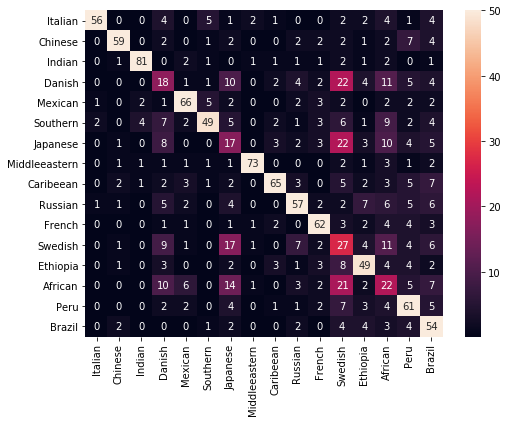

In [1030]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, vmin=0.1, vmax=50, xticklabels=cuisines, yticklabels=cuisines, annot=True);

In [1031]:
xgb_clf = xgb.XGBClassifier(max_depth=5,
                        objective='multi:softmax',
                        learning_rate=0.05, eval_metric='mlogloss')
xgb_clf.fit(train_word_features.tocsc(), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [1032]:
y_pred = xgb_clf.predict(test_word_features.tocsc())

In [1033]:
xgb_clf.score(test_word_features.tocsc(), y_test)

0.5864022662889519

In [1034]:
cm = confusion_matrix(y_test, y_pred)

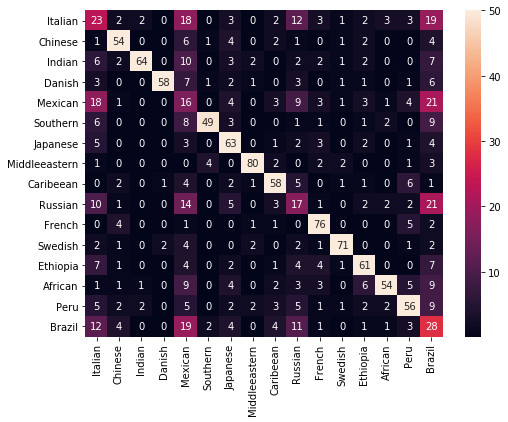

In [1035]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, vmin=0.1, vmax=50, xticklabels=cuisines, yticklabels=cuisines, annot=True);

#### Find model with merged cuisines

In [1039]:
texts = []
labels = []
for c, s in zip(recipes_df.Merge_recipes, recipes_df.Ingredients):
    if len(s) > 0:
        texts.append(s)
        labels.append(c)
        
print(len(texts), len(labels))

4705 4705


In [1040]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words=new_stop_words,
    ngram_range=(1, 1),
    max_features=500)

In [1041]:
word_vectorizer.fit(texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'could', 'will', 'then', 'well', 'each', 'in', 'whither', 'moreover', 'my', 'almost', 're', 'under', 'anything', 'for', 'whether', 'whereby', 'hasnt', 'here', 'around', 'cut', 'slices', 'interest', 'anyone', 'becoming', 'latter', 'again', 'be', 'mostly', 'off', 'about', 'everyo...via', 'already', 'by', 'pounds', 'whose', 'latterly', 'must', 'the', 'cry', 'your', 'four', 'none'}),
        strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [1042]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3,
                                                    shuffle=True, stratify=None)

In [1043]:
train_word_features = word_vectorizer.transform(X_train)

In [1044]:
test_word_features = word_vectorizer.transform(X_test)

In [1045]:
classifier = LogisticRegression(C=1e3, solver='lbfgs', multi_class='multinomial')
#cv_score = np.mean(cross_val_score(classifier, train_word_features, 
#                                       train_target, cv=3, scoring='roc_auc'))
#scores.append(cv_score)
#print('CV score for class {} is {}'.format(class_name, cv_score))
classifier.fit(train_word_features, y_train)
y_pred = classifier.predict(test_word_features)#, y_test)
classifier.score(test_word_features, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.6041076487252125

In [1047]:
cm = confusion_matrix(y_test, y_pred)

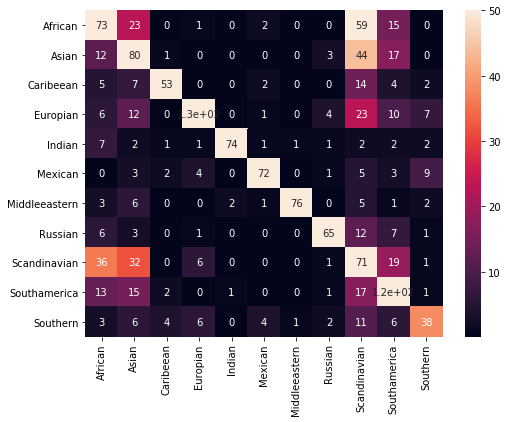

In [1051]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, vmin=0.1, vmax=50, xticklabels=ticklabel, yticklabels=ticklabel, annot=True);

# plt.imshow(cm, vmin=0.1, vmax=50)
# plt.xticks(np.arange(10), ticklabel, rotation=90)#

In [947]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(stop_w)

In [1060]:
def return_word_count(df, fname, ylabel='No of items', word_count=15):
    count = np.arange(word_count)
    freq_text = ' '
    for i, s in enumerate(df.Ingredients):
        freq_text = freq_text + ' ' + s

    freq_text = word_tokenize(freq_text)
    new_freq_text = []
    for r in freq_text: 
        if not r in stopwords: 
            new_freq_text.append(r)
    freqDist = nltk.FreqDist(new_freq_text)

    sorted_freqDist= sorted(freqDist.items(), key=lambda kv: kv[1])
    sorted_dict = np.array(sorted_freqDist)
    
    plt.figure(figsize=(6, 6))
    plt.plot(count, sorted_dict[:,1][-word_count:][::-1].astype(int))
    plt.xticks(count, sorted_dict[:,0][-word_count:][::-1], rotation=90)
    plt.ylabel(ylabel)
    plt.savefig(fname)



(4842, 18)


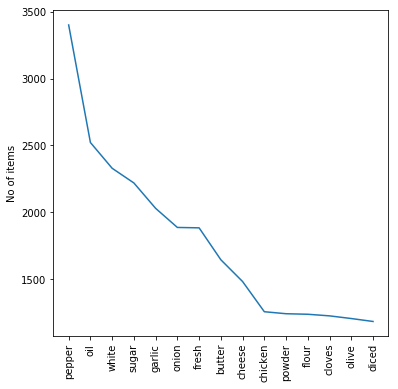

In [1059]:
return_word_count(recipes_df, 'word_count.png')

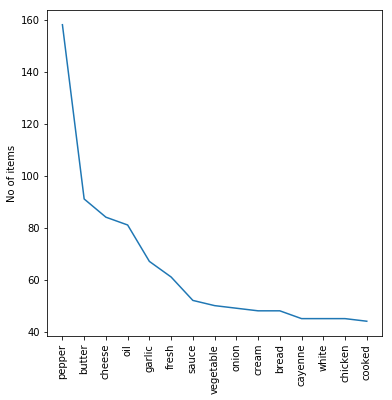

In [1061]:
return_word_count(recipes_df[recipes_df.Calorie > 800], 'high_calorie_word_count.png')

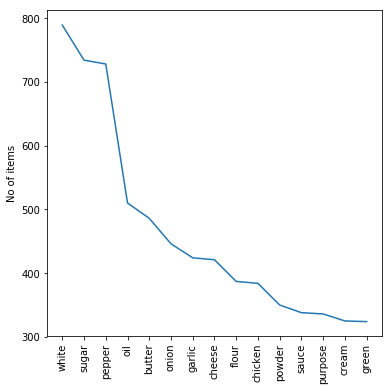

In [1062]:
return_word_count(recipes_df[recipes_df.Review > 500], 'high_review_word_count.png')

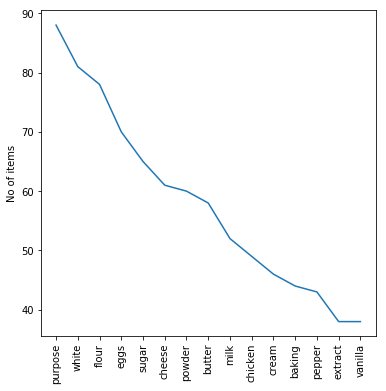

In [1064]:
return_word_count(recipes_df[recipes_df.People_made_it > 5000], 'high_made_word_count.png')

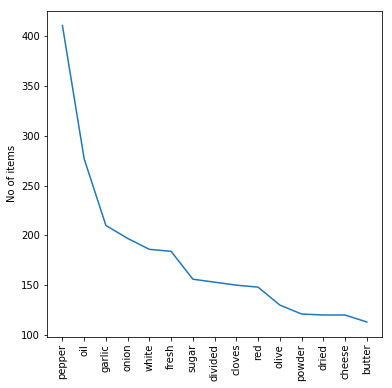

In [1070]:
return_word_count(recipes_df[(recipes_df.People_made_it < 50) & (recipes_df.People_made_it > 20)],
                            'low_made_word_count.png')

In [1071]:
recipes_df.Rating.head(1)

0    4.566503
Name: Rating, dtype: float64

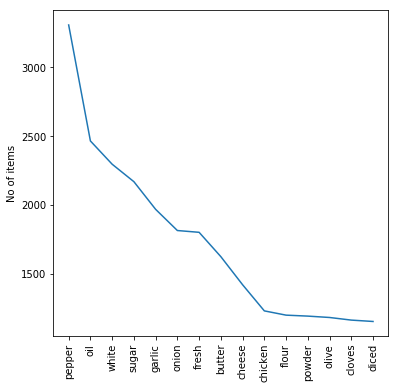

In [1075]:
return_word_count(recipes_df[recipes_df.Rating >= 4], 'high_rating_word_count.png')

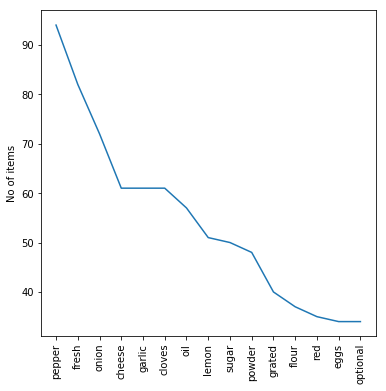

In [1076]:
return_word_count(recipes_df[recipes_df.Rating < 4], 'low_rating_word_count.png')